In [5]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import import_ipynb
import preprocessing as pre
import torchvision.models as models
import torch.nn as nn


<Figure size 432x288 with 0 Axes>

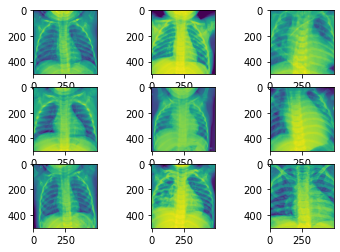

In [3]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0][0].imshow(pre.dataset[300][0][0])
axarr[1][0].imshow(pre.dataset[400][0][0])
axarr[2][0].imshow(pre.dataset[500][0][0])

axarr[0][1].imshow(pre.dataset_val[1][0][0])
axarr[1][1].imshow(pre.dataset_val[4][0][0])
axarr[2][1].imshow(pre.dataset_val[15][0][0])

axarr[0][2].imshow(pre.dataset_test[300][0][0])
axarr[1][2].imshow(pre.dataset_test[400][0][0])
axarr[2][2].imshow(pre.dataset_test[500][0][0])

# LOAD PRE-TRAINED NETWORKS

In [4]:
alex_net = models.alexnet(pretrained= True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Thomas/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [26]:
print(alex_net.features)
for param in alex_net.parameters():
    param.requires_grad = False

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [19]:
class Model(nn.Module):
    def __init__(self, num_classes = 2):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(in_features=50176, out_features=500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=500, out_features=num_classes)

    def forward(self, inp):

        output = self.fc1(inp)
        output = self.relu(output)
        output = self.fc2(output)
        return output

In [27]:
linear_model = Model(num_classes = 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linear_model.parameters(),lr = 0.005)
epochs = 10

In [31]:
loss_data = []
validation_loss = []

#training of network
for epoch in range(epochs):
    print('\rEpoch: [{}/{}]'.format(epoch+1, epochs),end='')
    epoch_loss = 0
    epoch_validation_loss = 0
    for batch_nr, (images, labels) in enumerate(pre.train_loader):
        
        out = alex_net.features(images)
        out = out.view(len(images), 50176)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        predict = linear_model.forward(out)
        # calculate-the-batch-loss
        loss = criterion(predict, labels)
        epoch_loss +=loss
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
         #perform-a-ingle-optimization-step (parameter-update)
        optimizer.step() 
         #update-training-loss
            
    # Validation
    for batch_nr, (images, labels) in enumerate(pre.val_loader):
        out = alex_net.features(images)
        out = out.view(len(images), 50176)
        
        predict = linear_model.forward(out)
        val_loss = criterion(predict, labels)
        epoch_validation_loss += val_loss

    loss_data.append(epoch_loss/len(pre.train_loader))
    validation_loss.append(epoch_validation_loss)

Epoch: [10/10]

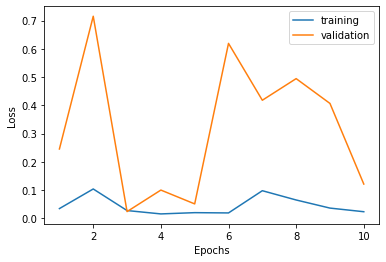

In [32]:
plt.plot(range(1,epochs+1), loss_data,label='training')
plt.plot(range(1,epochs+1),validation_loss, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
#Testing 
correct = 0
total = 0
confusion = np.array([[0,0],[0,0]])
for batch_nr, (images, labels) in enumerate(pre.test_loader):
    print('\rBatch: [{}/{}]'.format(batch_nr+1, len(pre.test_loader)),end='')
    out = alex_net.features(images)
    out = out.view(len(images), 50176)
    
    predict = linear_model.forward(out)
    for i in range(len(images)):
        
        preede = torch.argmax(predict[i])
        is_correct = preede == labels[i]
        
        if(preede == labels[i]):
            correct +=1
        total += 1
        if(labels[i] == 0):
            if(is_correct):
                confusion[0][0] += 1
            else:
                confusion[1][0] += 1
        if(labels[i] == 1):
            if(is_correct):
                confusion[1][1] += 1
            else:
                confusion[0][1] += 1

print("\nCorrect : ", correct)
print("Total : ", total)
print("Accuracy : " , correct/total*100 , "%")

#plt.imshow(images[0][0])
print(confusion)

Batch: [39/39]
Correct :  525
Total :  624
Accuracy :  84.13461538461539 %
[[141   6]
 [ 93 384]]


In [39]:
torch.save(alex_net.state_dict(), './models/pretrained/alex_net.pt')

In [41]:
torch.save(linear_model.state_dict(), './models/pretrained/alex_net_linear.pt')

In [48]:
vgg16 = models.vgg16(pretrained= True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Thomas/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [51]:
#print(inception.features)
for param in inception.parameters():
    param.requires_grad = False

In [56]:
class Model_vgg16(nn.Module):
    def __init__(self, num_classes = 2):
        super(Model_vgg16, self).__init__()

        self.fc1 = nn.Linear(in_features=115200, out_features=500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=500, out_features=num_classes)

    def forward(self, inp):

        output = self.fc1(inp)
        output = self.relu(output)
        output = self.fc2(output)
        return output

In [57]:
linear_model_vgg16 = Model_vgg16(num_classes = 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linear_model_vgg16.parameters(),lr = 0.005)
epochs = 10

In [ ]:
loss_data = []
validation_loss = []

#training of network
for epoch in range(epochs):
    print('\rEpoch: [{}/{}]'.format(epoch+1, epochs),end='')
    epoch_loss = 0
    epoch_validation_loss = 0
    for batch_nr, (images, labels) in enumerate(pre.train_loader):
        
        out = vgg16.features(images)
        out = out.view(len(images), 115200)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        predict = linear_model_vgg16.forward(out)
        # calculate-the-batch-loss
        loss = criterion(predict, labels)
        epoch_loss +=loss
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
         #perform-a-ingle-optimization-step (parameter-update)
        optimizer.step() 
         #update-training-loss
            
    # Validation
    for batch_nr, (images, labels) in enumerate(pre.val_loader):
        out = vgg16.features(images)
        out = out.view(len(images), 115200)
        
        predict = linear_model_vgg16.forward(out)
        val_loss = criterion(predict, labels)
        epoch_validation_loss += val_loss

    loss_data.append(epoch_loss/len(pre.train_loader))
    validation_loss.append(epoch_validation_loss)

Epoch: [1/10]